In [140]:
import os
import sys
import random
import warnings
import cv2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 152
IMG_HEIGHT = 60
IMG_CHANNELS = 3

TRAIN_PATH='C:/Users/jmlee/Desktop/4학년 1학기/졸프/U-Net/x_train_new/'
TEST_PATH ='C:/Users/jmlee/Desktop/4학년 1학기/졸프/U-Net/x_test_new/'
MASK_TRAIN='C:/Users/jmlee/Desktop/4학년 1학기/졸프/U-Net/y_train_new/'



warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [141]:
tf. version

<module 'tensorflow._api.v1.version' from 'C:\\Users\\jmlee\\anaconda3\\lib\\site-packages\\tensorflow\\_api\\v1\\version\\__init__.py'>

## Train, Test

In [142]:
# #한글이름 사진 로드
from PIL import Image

#gray로 불러와야 threshold  함수 사용가능
def hangulFilePathImageRead2 (filePath ) :  
    stream = open(filePath.encode("utf-8") , "rb")
    bytes = bytearray(stream.read())
    numpyArray = np.asarray(bytes, dtype=np.uint8)

    return cv2.imdecode(numpyArray , cv2.IMREAD_GRAYSCALE)

# def hangulFilePathImageRead (filePath ) :

#     stream = open( filePath.encode("utf-8") , "rb")
#     bytes = bytearray(stream.read())
#     numpyArray = np.asarray(bytes, dtype=np.uint8)

#     return cv2.imdecode(numpyArray , cv2.IMREAD_COLOR)  #3채널로 가져오기

# #train
# if __name__ == '__main__':
#     train_mask_=[]
#     train__=[]
#     for f in os.listdir(TRAIN_PATH):  
#         if f.split('.')[1] =='jpg':
#             filePath = r'C:/Users/jmlee/Desktop/4학년 1학기/졸프/U-Net/정맥전체(.jpg)'+'/'+f
#             train_= hangulFilePathImageRead2(filePath)  #이미지
#             train__.append(train_)
#             train_mask = cv2.adaptiveThreshold(train_,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,19, 15) #마스크
#             train_mask_.append(train_mask)
            
            
            
# #test
# if __name__ == '__main__':
#     test_mask_=[]
#     test__=[]
#     for f_ in os.listdir(TEST_PATH):  
#         if f_.split('.')[1] =='jpg':
#             filePath = (r"C:/Users/jmlee/Desktop/4학년 1학기/졸프/U-Net/input_test"+'/'+f_)  
#             test_ = hangulFilePathImageRead2(filePath)  #이미지
#             test__.append(test_)
#             test_mask = cv2.adaptiveThreshold(test_,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,19, 15)  #마스크
#             test_mask_.append(test_mask)
            
# #             print(f_)

In [143]:
# Get train and test IDs
# train_path=os.walk(TRAIN_PATH)  #agumenatation한것_에러 안남
# train_ids = next(train_path)[2]

train_path=os.walk(TRAIN_PATH) #raw
train_ids= next(train_path)[2]

test_path=os.walk(TEST_PATH)
test_ids = next(test_path)[2]

mask_path=os.walk(MASK_TRAIN)
mask_ids = next(mask_path)[2]


In [10]:
a=np.array(train_ids)
a.shape

(1880,)

In [145]:
train_ids

['[SEG]강병준_1_1.jpg',
 '[SEG]강병준_1_1_0_1862.jpg',
 '[SEG]강병준_1_1_0_2218.jpg',
 '[SEG]강병준_1_1_0_5481.jpg',
 '[SEG]강병준_1_1_0_5973.jpg',
 '[SEG]강병준_1_1_0_7302.jpg',
 '[SEG]강병준_1_1_0_764.jpg',
 '[SEG]강병준_1_1_0_7685.jpg',
 '[SEG]강병준_1_1_0_8136.jpg',
 '[SEG]강병준_1_1_0_9716.jpg',
 '[SEG]강병준_2_1.jpg',
 '[SEG]강병준_2_1_0_1632.jpg',
 '[SEG]강병준_2_1_0_331.jpg',
 '[SEG]강병준_2_1_0_3936.jpg',
 '[SEG]강병준_2_1_0_4556.jpg',
 '[SEG]강병준_2_1_0_6768.jpg',
 '[SEG]강병준_2_1_0_8011.jpg',
 '[SEG]강병준_2_1_0_8500.jpg',
 '[SEG]강병준_2_1_0_8898.jpg',
 '[SEG]강병준_2_1_0_9207.jpg',
 '[SEG]강병준_3_1.jpg',
 '[SEG]강병준_3_1_0_1277.jpg',
 '[SEG]강병준_3_1_0_1303.jpg',
 '[SEG]강병준_3_1_0_1483.jpg',
 '[SEG]강병준_3_1_0_1534.jpg',
 '[SEG]강병준_3_1_0_3253.jpg',
 '[SEG]강병준_3_1_0_3958.jpg',
 '[SEG]강병준_3_1_0_4163.jpg',
 '[SEG]강병준_3_1_0_819.jpg',
 '[SEG]강병준_3_1_0_9674.jpg',
 '[SEG]강병준_4_1.jpg',
 '[SEG]강병준_4_1_0_1587.jpg',
 '[SEG]강병준_4_1_0_2114.jpg',
 '[SEG]강병준_4_1_0_3353.jpg',
 '[SEG]강병준_4_1_0_4813.jpg',
 '[SEG]강병준_4_1_0_4843.jpg',
 '[SEG]강병준_4_1_0_4875.j

In [12]:
mask_ids

['[SEG]강병준_1_1 - 복사본 (2).jpg',
 '[SEG]강병준_1_1 - 복사본 (3).jpg',
 '[SEG]강병준_1_1 - 복사본 (4).jpg',
 '[SEG]강병준_1_1 - 복사본 (5).jpg',
 '[SEG]강병준_1_1 - 복사본 (6).jpg',
 '[SEG]강병준_1_1 - 복사본 (7).jpg',
 '[SEG]강병준_1_1 - 복사본 (8).jpg',
 '[SEG]강병준_1_1 - 복사본 (9).jpg',
 '[SEG]강병준_1_1 - 복사본.jpg',
 '[SEG]강병준_1_1.jpg',
 '[SEG]강병준_2_1  - 복사본 (2).jpg',
 '[SEG]강병준_2_1  - 복사본 (3).jpg',
 '[SEG]강병준_2_1  - 복사본 (4).jpg',
 '[SEG]강병준_2_1  - 복사본 (5).jpg',
 '[SEG]강병준_2_1  - 복사본 (6).jpg',
 '[SEG]강병준_2_1  - 복사본 (7).jpg',
 '[SEG]강병준_2_1  - 복사본 (8).jpg',
 '[SEG]강병준_2_1  - 복사본 (9).jpg',
 '[SEG]강병준_2_1  - 복사본.jpg',
 '[SEG]강병준_2_1 .jpg',
 '[SEG]강병준_3_1  - 복사본 (2).jpg',
 '[SEG]강병준_3_1  - 복사본 (3).jpg',
 '[SEG]강병준_3_1  - 복사본 (4).jpg',
 '[SEG]강병준_3_1  - 복사본 (5).jpg',
 '[SEG]강병준_3_1  - 복사본 (6).jpg',
 '[SEG]강병준_3_1  - 복사본 (7).jpg',
 '[SEG]강병준_3_1  - 복사본 (8).jpg',
 '[SEG]강병준_3_1  - 복사본 (9).jpg',
 '[SEG]강병준_3_1  - 복사본.jpg',
 '[SEG]강병준_3_1 .jpg',
 '[SEG]강병준_4_1  - 복사본 (2).jpg',
 '[SEG]강병준_4_1  - 복사본 (3).jpg',
 '[SEG]강병준_4_1  - 복사본 (4).jp

In [13]:
test_ids

['[SEG]정대식_2_1.jpg',
 '[SEG]정대식_2_1_0_1496.jpg',
 '[SEG]정대식_2_1_0_229.jpg',
 '[SEG]정대식_2_1_0_2720.jpg',
 '[SEG]정대식_2_1_0_4373.jpg',
 '[SEG]정대식_2_1_0_442.jpg',
 '[SEG]정대식_2_1_0_5659.jpg',
 '[SEG]정대식_2_1_0_8028.jpg',
 '[SEG]정대식_2_1_0_8399.jpg',
 '[SEG]정대식_2_1_0_8538.jpg',
 '[SEG]정대식_3_1.jpg',
 '[SEG]정대식_3_1_0_1255.jpg',
 '[SEG]정대식_3_1_0_1910.jpg',
 '[SEG]정대식_3_1_0_2976.jpg',
 '[SEG]정대식_3_1_0_3487.jpg',
 '[SEG]정대식_3_1_0_389.jpg',
 '[SEG]정대식_3_1_0_4347.jpg',
 '[SEG]정대식_3_1_0_5047.jpg',
 '[SEG]정대식_3_1_0_6583.jpg',
 '[SEG]정대식_3_1_0_9537.jpg',
 '[SEG]정대식_4_1.jpg',
 '[SEG]정대식_4_1_0_2581.jpg',
 '[SEG]정대식_4_1_0_2593.jpg',
 '[SEG]정대식_4_1_0_3817.jpg',
 '[SEG]정대식_4_1_0_4067.jpg',
 '[SEG]정대식_4_1_0_4574.jpg',
 '[SEG]정대식_4_1_0_7242.jpg',
 '[SEG]정대식_4_1_0_7484.jpg',
 '[SEG]정대식_4_1_0_9122.jpg',
 '[SEG]정대식_4_1_0_9713.jpg',
 '[SEG]정대식_6_1.jpg',
 '[SEG]정대식_6_1_0_1303.jpg',
 '[SEG]정대식_6_1_0_1797.jpg',
 '[SEG]정대식_6_1_0_2138.jpg',
 '[SEG]정대식_6_1_0_238.jpg',
 '[SEG]정대식_6_1_0_4845.jpg',
 '[SEG]정대식_6_1_0_5737.jp

## 추출된 이미지
이진화 한 것을 mask에 저장

In [89]:
# import cv2
# import numpy as np 
# from matplotlib import pyplot as plt 


# #gray로 불러와야 threshold  함수 사용가능
# def hangulFilePathImageRead2 (filePath ) :  
#     stream = open( filePath.encode("utf-8") , "rb")
#     bytes = bytearray(stream.read())
#     numpyArray = np.asarray(bytes, dtype=np.uint8)

#     return cv2.imdecode(numpyArray , cv2.IMREAD_GRAYSCALE)

# img=hangulFilePathImageRead2(r'C:/Users/jmlee/Desktop/U-Net/정맥추출_train/[SEG]김보나_7_1.jpg')

# ret, th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)

# gaussian = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
# cv2.THRESH_BINARY,15,8)

# mean1 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
# cv2.THRESH_BINARY,11, 7)

# mean2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
# cv2.THRESH_BINARY,19, 15)

# mean3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
# cv2.THRESH_BINARY,15, 11)

# titles = ['img','gaussian','mean1','mean2','mean3']

# images = [img,gaussian,mean1,mean2,mean3]

# for i in range(5):
# 	plt.subplot(3,3,i+1),plt.imshow(images[i],'gray')
# 	plt.title(titles[i])
# 	plt.xticks([]),plt.yticks([])

# plt.show()

In [90]:
# mean2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
# cv2.THRESH_BINARY,19, 15)

In [91]:
a = np.array([[1,2,3,4], [5,6,7,8], [9,10,11,12]])
print(a)
a.shape # (3,4)
a.ndim # 2


[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]]


2

In [61]:
b = np.array([[1,2,3,4], [5,6,7,8], [9,10,11]])
print(b)
b.shape # (3,)
b.ndim # 1

[list([1, 2, 3, 4]) list([5, 6, 7, 8]) list([9, 10, 11])]


1

## 데이터 전처리

In [92]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    img = imread(TRAIN_PATH+id_)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img

for n, id_ in tqdm(enumerate(mask_ids), total=len(mask_ids)):
#adaptive input은 2차원이어야함. 
    #mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    train_= hangulFilePathImageRead2(MASK_TRAIN+id_) #2차원으로 불러오는 코드 
    mask_=cv2.adaptiveThreshold(train_,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,11, 7) 
    mask_= np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
    #mask = np.maximum(mask, mask_)
    Y_train[n] = mask_

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    img = imread(TEST_PATH+id_)[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|█████████████████████████████████████████████████████████████████████████████| 1880/1880 [00:12<00:00, 152.47it/s]

Getting and resizing test images ... 



100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:14<00:00, 41.13it/s]

Done!


In [93]:
train_.shape

(60, 152)

In [94]:
print(train_)

[[  0   0   0 ...  82 193 206]
 [  0   0   0 ...  87 195 207]
 [  0   0   0 ...  90 196 206]
 ...
 [  6   8  10 ...  70 190 206]
 [  3   3   5 ...  60 188 209]
 [  0   0   1 ...  42 185 214]]


In [95]:
np.array(sizes_test).shape

(600, 2)

In [96]:
X_train.shape

(1880, 60, 152, 3)

In [97]:
Y_train.shape

(1880, 60, 152, 1)

In [98]:
print(train_)

[[  0   0   0 ...  82 193 206]
 [  0   0   0 ...  87 195 207]
 [  0   0   0 ...  90 196 206]
 ...
 [  6   8  10 ...  70 190 206]
 [  3   3   5 ...  60 188 209]
 [  0   0   1 ...  42 185 214]]


In [99]:
mask_.shape #3차원

(60, 152, 1)

In [100]:
img.shape  #3차원

(60, 152, 3)

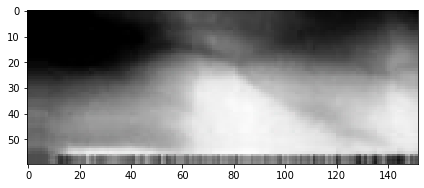

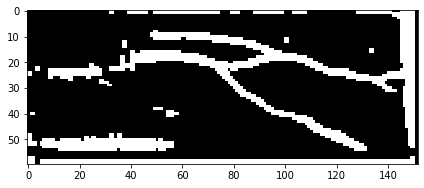

In [101]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [ ]:
type(X_train[1])

In [ ]:
# # Define IoU metric
# def mean_iou(y_true, y_pred):
#     prec = []
#     for t in np.arange(0.5, 1.0, 0.05):
#         y_pred_ = tf.to_int32(y_pred > t)
#         score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
#         K.get_session().run(tf.local_variables_initializer())
#         with tf.control_dependencies([up_opt]):
#             score = tf.identity(score)
#         prec.append(score)
#     return K.mean(K.stack(prec), axis=0)

# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2, y_true)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [103]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

In [104]:
s.shape

TensorShape([Dimension(None), Dimension(60), Dimension(152), Dimension(3)])

In [105]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf
from tensorflow.python.keras.metrics import Metric
from keras import metrics

# Build U-Net model
s = Lambda(lambda x: x / 255) (inputs)
print(s)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
print("c1",c1)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
print("c1",c1)
p1 = MaxPooling2D((2, 2)) (c1)
print("p1",p1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
print("c2",c2)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
print("c2",c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
print("c3",c3)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
print("c3",c3)
p3 = MaxPooling2D((2, 2)) (c3)
print("p3",p3)

c4 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.3) (c4)
c4 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)

u5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c4)
u5 = concatenate([u5, c3])
c5 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u5)
c5 = Dropout(0.2) (c5)
c5 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c1])
c6 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.1) (c6)
c6 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

# u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
# u9 = concatenate([u9, c1], axis=3)
# c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
# c9 = Dropout(0.1) (c9)
# c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c6)
#mIOU = tf.keras.metrics.MeanIoU(num_classes=20)
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

Tensor("lambda_6/truediv:0", shape=(?, 60, 152, 3), dtype=float32)
c1 Tensor("conv2d_27/Elu:0", shape=(?, 60, 152, 16), dtype=float32)
c1 Tensor("conv2d_28/Elu:0", shape=(?, 60, 152, 16), dtype=float32)
p1 Tensor("max_pooling2d_5/MaxPool:0", shape=(?, 30, 76, 16), dtype=float32)
c2 Tensor("conv2d_29/Elu:0", shape=(?, 30, 76, 32), dtype=float32)
c2 Tensor("conv2d_30/Elu:0", shape=(?, 30, 76, 32), dtype=float32)
c3 Tensor("conv2d_31/Elu:0", shape=(?, 30, 76, 64), dtype=float32)
c3 Tensor("conv2d_32/Elu:0", shape=(?, 30, 76, 64), dtype=float32)
p3 Tensor("max_pooling2d_6/MaxPool:0", shape=(?, 15, 38, 64), dtype=float32)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 60, 152, 3)   0                                            
_____________________________________________________________

In [78]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=1, 
                    callbacks=[earlystopper, checkpointer])

Train on 1692 samples, validate on 188 samples
Epoch 1/1
1692/1692 [==============================] - 431s 255ms/step - loss: 0.4743 - mean_iou: 0.1113 - val_loss: 0.4777 - val_mean_iou: 0.1236

Epoch 00001: val_loss improved from inf to 0.47774, saving model to model-dsbowl2018-1.h5


In [107]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)  #훈련
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1) #검증
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

600/600 [==============================] - 28s 47ms/step


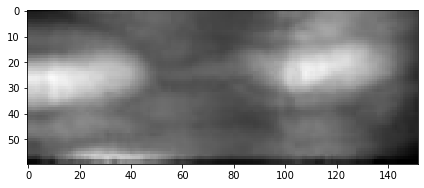

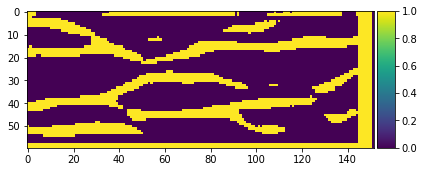

In [36]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_test[ix])
# plt.show()
# imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.show()

In [35]:
#유사도 검사

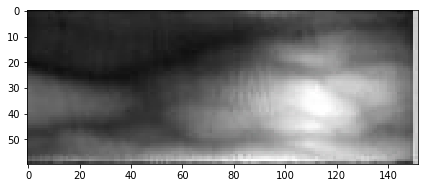

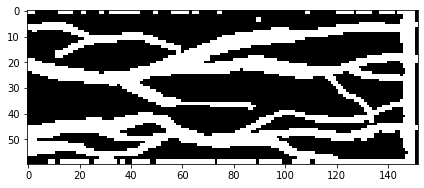

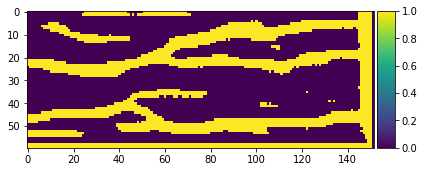

In [29]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [29]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [30]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [28]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-1.csv', index=False)

## 결과이미지 원본에 대입

In [68]:
#결과 가져오기
from PIL import Image
import glob
image_list = []
for filename in glob.glob('x_test_result/*.jpg'): 
    im=Image.open(filename)
    image_list.append(im)

In [69]:
#원본 가져오기
from PIL import Image
import glob
image_list2 = []
for filename in glob.glob('x_test_new/*.jpg'): 
    im=Image.open(filename)
    image_list2.append(im)

In [72]:
a=len(image_list)
for i in range(0,a):
    image_array = np.asarray(image_list[i])  #결과를 array로 
    imagem = cv2.bitwise_not(image_array)  #흑백반전
    image_array2 = np.asarray(image_list2[i]) #원본을 array로
    image_array2 = cv2.cvtColor(image_array2, cv2.COLOR_BGR2GRAY)  #image_array2가 비트사이즈가 24이므로 gray스케일로 바꿔줌.

In [73]:
image_array2.shape 

(60, 152)

In [74]:
image_array.shape #비트사이즈 8

(60, 152)

## 세선화

In [181]:
#결과 가져오기
from PIL import Image
import glob
image_list = []
for filename in glob.glob('x_test_result/*.jpg'):   #한개는 못넣음?
    im=Image.open(filename)
    image_list.append(im)

In [182]:
#원본 가져오기
from PIL import Image
import glob
import numpy as np
from skimage.io import imsave
image_list2 = []
name=[]

x_test_name=[]
os.listdir(TEST_PATH).sort()
for f in os.listdir(TEST_PATH):  
    if f.split('.')[1] =='jpg' or f.split('.')[1]=='bmp':
        x_test_name.append(f.split('.')[0])   #이미지 이름
    
# for filename in glob.glob('x_test_new/*.jpg'): #원본가져오기(name이 append안됨. 왜?)
#     im=Image.open(filename)
#     name=filename.split('.')[0]
#     name=name.split('\\')[1]
#     image_list2.append(im)
#     name.append(name.split('\\')[1])

for filename in glob.glob('x_test_new/*.jpg'): #원본가져오기(name이 append안됨. 왜?)
    im=Image.open(filename)
    image_list2.append(im)


for i in range(0,2):  
    image_array2 = np.asarray(image_list2[i]) #원본을 array로
    image_array2 = cv2.cvtColor(image_array2, cv2.COLOR_BGR2GRAY)  #image_array2가 비트사이즈가 24이므로 gray스케일로 바꿔줌.

In [184]:
def join(imagem,image_array2):  #세선화, 원본
    for i in range(0,60):
        for j in range(0,152):
            if(imagem[i][j]==True):  #정맥이면
                image_array2[i][j]=0
                
    return image_array2

In [185]:
image_array2.shape

(60, 152)

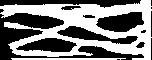

In [186]:
image_list[1]

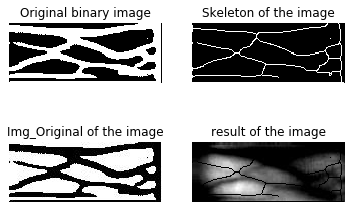

In [193]:
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
from skimage import filters
import cv2
from skimage.io import imsave
"load image data"
path='C:/Users/jmlee/Desktop/4학년 1학기/졸프/U-Net/result'
for i in range(0,1):
    image_array = np.asarray(image_list[i])  #결과를 array로 
    Img_Original = cv2.bitwise_not(image_array)  #흑백반전
    Otsu_Threshold = filters.threshold_otsu(Img_Original)   #Img_Original=np.array타입, (60.152)크기
    BW_Original = Img_Original < Otsu_Threshold    # must set object region as 1, background region as 0 
    BW_Skeleton = zhangSuen(BW_Original)  #세선화(bool타입)
    
    image_array2.setflags(write=1)
    result=join(BW_Skeleton,image_array2)  #합치기(세선화, 원본)
    cv2.imwrite(os.path.join(path ,x_test_name[i]+'.jpg'), result)
    
def neighbours(x,y,image):
    "Return 8-neighbours of image point P1(x,y), in a clockwise order"
    img = image
    x_1, y_1, x1, y1 = x-1, y-1, x+1, y+1
    return [ img[x_1][y], img[x_1][y1], img[x][y1], img[x1][y1],     # P2,P3,P4,P5
                img[x1][y], img[x1][y_1], img[x][y_1], img[x_1][y_1] ]    # P6,P7,P8,P9

def transitions(neighbours):
    "No. of 0,1 patterns (transitions from 0 to 1) in the ordered sequence"
    n = neighbours + neighbours[0:1]      # P2, P3, ... , P8, P9, P2
    return sum( (n1, n2) == (0, 1) for n1, n2 in zip(n, n[1:]) )  # (P2,P3), (P3,P4), ... , (P8,P9), (P9,P2)

def zhangSuen(image):
    "the Zhang-Suen Thinning Algorithm"
    Image_Thinned = image.copy()  # deepcopy to protect the original image
    changing1 = changing2 = 1        #  the points to be removed (set as 0)
    while changing1 or changing2:   #  iterates until no further changes occur in the image
        # Step 1
        changing1 = []
        rows, columns = Image_Thinned.shape               # x for rows, y for columns
        for x in range(1, rows - 1):                     # No. of  rows
            for y in range(1, columns - 1):            # No. of columns
                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(x, y, Image_Thinned)
                if (Image_Thinned[x][y] == 1     and    # Condition 0: Point P1 in the object regions 
                    2 <= sum(n) <= 6   and    # Condition 1: 2<= N(P1) <= 6
                    transitions(n) == 1 and    # Condition 2: S(P1)=1  
                    P2 * P4 * P6 == 0  and    # Condition 3   
                    P4 * P6 * P8 == 0):         # Condition 4
                    changing1.append((x,y))
        for x, y in changing1: 
            Image_Thinned[x][y] = 0

        # Step 2
        changing2 = []
        for x in range(1, rows - 1):
            for y in range(1, columns - 1):
                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(x, y, Image_Thinned)
                if (Image_Thinned[x][y] == 1   and        # Condition 0
                    2 <= sum(n) <= 6  and       # Condition 1
                    transitions(n) == 1 and      # Condition 2
                    P2 * P4 * P8 == 0 and       # Condition 3
                    P2 * P6 * P8 == 0):            # Condition 4
                    changing2.append((x,y))    
        for x, y in changing2: 
            Image_Thinned[x][y] = 0
    return Image_Thinned


# "Apply the algorithm on images"
# BW_Skeleton = zhangSuen(BW_Original)

# BW_Skeleton = BW_Original
"Display the results"
fig, ax = plt.subplots(2, 2)
ax1, ax2,ax3,ax4 = ax.ravel()
ax1.imshow(BW_Original, cmap=plt.cm.gray)
ax1.set_title('Original binary image')
ax1.axis('off')
ax2.imshow(BW_Skeleton, cmap=plt.cm.gray)
ax2.set_title('Skeleton of the image')
ax2.axis('off')
ax3.imshow(Img_Original, cmap=plt.cm.gray)
ax3.set_title('Img_Original of the image')
ax3.axis('off')
ax4.imshow(result, cmap=plt.cm.gray)
ax4.set_title('result of the image')
ax4.axis('off')
plt.show()

In [188]:
BW_Skeleton.shape

(60, 152)